In [ ]:
import polars as pl
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import optax  # Optimizadores para JAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import tqdm
from functools import partial
from joblib import Parallel, delayed
from datetime import timedelta, datetime

# Seguimos usando gym/gymnasium para definiciones de entornos
import gym
import gymnasium as gym
from gymnasium import spaces

# Configuramos JAX para usar precisión de 64 bits para mejor estabilidad numérica
jax.config.update("jax_enable_x64", True)

PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Configuración global
CONFIG = {
    "batch_size": 128,
    "window_hours": 2,
    "cap_normal": 30,
    "cap_bg": 300,
    "cap_iob": 5,
    "cap_carb": 150,
    "data_path": os.path.join(PROJECT_DIR, "data", "subjects"),
    "jax_seed": 42  # Semilla para operaciones aleatorias en JAX
}

In [2]:
def get_cgm_window(bolus_time, cgm_df, window_hours=CONFIG["window_hours"]):
    """
    Obtiene una ventana de datos CGM alrededor del tiempo del bolo de insulina.
    
    Args:
        bolus_time (datetime): Tiempo del bolo de insulina
        cgm_df (pl.DataFrame): DataFrame con datos CGM
        window_hours (int): Tamaño de la ventana en horas
    
    Returns:
        np.ndarray: Array numpy con los últimos 24 valores CGM o None si no hay suficientes datos
    """
    window_start = bolus_time - timedelta(hours=window_hours)
    window = cgm_df.filter((pl.col('date') >= window_start) & (pl.col('date') <= bolus_time))
    window = window.sort('date').tail(24)
    return window['mg/dl'].to_numpy() if len(window) >= 24 else None

def calculate_iob(bolus_time, basal_df, half_life_hours=4):
    """
    Calcula la insulina activa (IOB) en un momento dado.
    
    Args:
        bolus_time (datetime): Tiempo para calcular IOB
        basal_df (pl.DataFrame): DataFrame con datos de insulina basal
        half_life_hours (int): Vida media de la insulina en horas
    
    Returns:
        float: Cantidad de insulina activa
    """
    if basal_df is None or len(basal_df) == 0:
        return 0.0
        
    iob = 0
    for row in basal_df.iter_rows(named=True):
        start_time = row['date']
        duration_hours = row['duration'] / (1000 * 3600)
        end_time = start_time + timedelta(hours=duration_hours)
        rate = row['rate'] if row['rate'] is not None else 0.9
        rate = min(rate, 2.0)
        
        if start_time <= bolus_time <= end_time:
            time_since_start = (bolus_time - start_time).total_seconds() / 3600
            remaining = rate * (1 - (time_since_start / half_life_hours))
            iob += max(0, remaining)
            
    return min(iob, 5.0)

def process_subject(subject_path, idx):
    """
    Procesa los datos de un sujeto del estudio.
    
    Args:
        subject_path (str): Ruta al archivo Excel con datos del sujeto
        idx (int): Índice/ID del sujeto
    
    Returns:
        list: Lista de diccionarios con características procesadas
    """
    start_time = time.time()
    
    try:
        cgm_df = pl.read_excel(subject_path, sheet_name="CGM")
        bolus_df = pl.read_excel(subject_path, sheet_name="Bolus")
        try:
            basal_df = pl.read_excel(subject_path, sheet_name="Basal")
        except Exception:
            basal_df = None
    except Exception as e:
        print(f"Error al cargar {os.path.basename(subject_path)}: {e}")
        return []

    cgm_df = cgm_df.with_columns(pl.col('date').cast(pl.Datetime))
    cgm_df = cgm_df.sort('date')
    bolus_df = bolus_df.with_columns(pl.col('date').cast(pl.Datetime))
    if basal_df is not None:
        basal_df = basal_df.with_columns(pl.col('date').cast(pl.Datetime))

    non_zero_carbs = bolus_df.filter(pl.col('carbInput') > 0)['carbInput']
    carb_median = non_zero_carbs.median() if len(non_zero_carbs) > 0 else 10.0

    iob_values = [calculate_iob(row['date'], basal_df) for row in bolus_df.iter_rows(named=True)]
    non_zero_iob = [iob for iob in iob_values if iob > 0]
    iob_median = np.median(non_zero_iob) if non_zero_iob else 0.5

    processed_data = []
    for row in tqdm(bolus_df.iter_rows(named=True), total=len(bolus_df), 
                   desc=f"Procesando {os.path.basename(subject_path)}", leave=False):
        bolus_time = row['date']
        cgm_window = get_cgm_window(bolus_time, cgm_df)
        
        if cgm_window is not None:
            iob = calculate_iob(bolus_time, basal_df)
            iob = iob_median if iob == 0 else iob
            hour_of_day = bolus_time.hour / 23.0
            bg_input = row['bgInput'] if row['bgInput'] is not None else cgm_window[-1]
            
            normal = row['normal'] if row['normal'] is not None else 0.0
            normal = np.clip(normal, 0, CONFIG["cap_normal"])
            
            bg_input = max(bg_input, 50.0)
            isf_custom = 50.0 if normal <= 0 else (bg_input - 100) / normal
            isf_custom = np.clip(isf_custom, 10, 100)
            
            bg_input = np.clip(bg_input, 0, CONFIG["cap_bg"])
            iob = np.clip(iob, 0, CONFIG["cap_iob"])
            carb_input = row['carbInput'] if row['carbInput'] is not None else 0.0
            carb_input = carb_median if carb_input == 0 else carb_input
            carb_input = np.clip(carb_input, 0, CONFIG["cap_carb"])
            
            features = {
                'subject_id': idx,
                'cgm_window': cgm_window,
                'carbInput': carb_input,
                'bgInput': bg_input,
                'insulinCarbRatio': np.clip(row['insulinCarbRatio'] if row['insulinCarbRatio'] is not None else 10.0, 5, 20),
                'insulinSensitivityFactor': isf_custom,
                'insulinOnBoard': iob,
                'hour_of_day': hour_of_day,
                'normal': normal
            }
            processed_data.append(features)

    elapsed_time = time.time() - start_time
    print(f"Procesado {os.path.basename(subject_path)} (Sujeto {idx+1}) en {elapsed_time:.2f} segundos")
    return processed_data

def process_and_convert_to_polars(all_processed_data):
    """
    Convierte los datos procesados a un DataFrame de Polars.
    
    Args:
        all_processed_data (list): Lista de diccionarios con características procesadas
    
    Returns:
        pl.DataFrame: DataFrame con todos los datos procesados
    """
    cgm_data = [item.pop('cgm_window') for item in all_processed_data]
    
    df_processed = pl.DataFrame(all_processed_data)
    
    cgm_columns = [f'cgm_{i}' for i in range(24)]
    cgm_arrays = np.array(cgm_data)
    
    cgm_df = pl.DataFrame({
        col_name: cgm_arrays[:, i] for i, col_name in enumerate(cgm_columns)
    })
    
    return pl.concat([cgm_df, df_processed], how="horizontal")

def preprocess_data(subject_folder):
    """
    Preprocesa los datos de todos los sujetos para el entrenamiento del modelo.
    
    Args:
        subject_folder (str): Ruta a la carpeta que contiene los archivos Excel de los sujetos
        
    Returns:
        pl.DataFrame: DataFrame con todos los datos procesados
    """
    start_time = time.time()
    
    subject_files = [f for f in os.listdir(subject_folder) if f.startswith("Subject") and f.endswith(".xlsx")]
    print(f"\nFound Subject files ({len(subject_files)}):")
    for f in subject_files:
        print(f)

    all_processed_data = Parallel(n_jobs=-1)(delayed(process_subject)(os.path.join(subject_folder, f), idx) 
                                            for idx, f in enumerate(subject_files))
    all_processed_data = [item for sublist in all_processed_data for item in sublist]

    df_final = process_and_convert_to_polars(all_processed_data)
    
    print("Muestra de datos procesados combinados:")
    print(df_final.head())
    print(f"Total de muestras: {len(df_final)}")

        # Aplicar transformaciones logarítmicas
    df_final = df_final.with_columns([
        pl.col('normal').log1p().alias('normal'),
        pl.col('carbInput').log1p().alias('carbInput'),
        pl.col('insulinOnBoard').log1p().alias('insulinOnBoard'),
        pl.col('bgInput').log1p().alias('bgInput')
    ])

    # Aplicar transformación logarítmica a las columnas CGM
    for col in [f'cgm_{i}' for i in range(24)]:
        df_final = df_final.with_columns(
            pl.col(col).log1p().alias(col)
        )
    
    df_final = df_final.drop_nulls()
    print("Verificación de NaN en df_final:")
    print(df_final.null_count())

    elapsed_time = time.time() - start_time
    print(f"Preprocesamiento completo en {elapsed_time:.2f} segundos")
    return df_final

def split_data(df_final):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba, asegurando distribuciones similares.
    Fuerza al Sujeto 49 a estar en el conjunto de prueba para evaluación y equilibra medias y desviaciones estándar.
    
    Args:
        df_final (pl.DataFrame): DataFrame con todos los datos
        
    Returns:
        tuple: Tupla con datos divididos para entrenamiento, validación y prueba y los escaladores
    """
    start_time = time.time()
    
    # Convertir a pandas para algunas operaciones específicas
    df_final_pd = df_final.to_pandas()
    
    # Compute the mean and std insulin dose for each subject
    subject_stats = df_final_pd.groupby('subject_id')['normal'].agg(['mean', 'std']).reset_index()
    subject_stats.columns = ['subject_id', 'mean_dose', 'std_dose']
    subject_ids = df_final_pd['subject_id'].unique()

    # Sort subjects by their mean insulin dose
    sorted_subjects = subject_stats.sort_values('mean_dose')['subject_id'].values
    n_subjects = len(sorted_subjects)

    # Aim for 80%-10%-10% split
    train_size = int(0.8 * n_subjects)  # 80% for training
    val_size = int(0.1 * n_subjects)    # 10% for validation
    test_size = n_subjects - train_size - val_size  # 10% for test

    # Force Subject 49 into the test set
    test_subjects = [49] if 49 in sorted_subjects else []
    remaining_subjects = [s for s in sorted_subjects if s != 49]
    train_subjects = []
    val_subjects = []

    # Initialize lists and track stats
    train_subjects = []
    val_subjects = []
    test_subjects = [49] if 49 in sorted_subjects else []

    # Assign subjects to minimize differences in means and stds
    remaining_subjects_list = list(remaining_subjects)
    np.random.shuffle(remaining_subjects_list)  # Shuffle to avoid bias in assignment order

    for i, subject in enumerate(remaining_subjects_list):
        # Compute current means and stds of each set
        train_mean = df_final_pd[df_final_pd['subject_id'].isin(train_subjects)]['normal'].mean() if train_subjects else 0
        val_mean = df_final_pd[df_final_pd['subject_id'].isin(val_subjects)]['normal'].mean() if val_subjects else 0
        test_mean = df_final_pd[df_final_pd['subject_id'].isin(test_subjects)]['normal'].mean() if test_subjects else 0
        train_std = df_final_pd[df_final_pd['subject_id'].isin(train_subjects)]['normal'].std() if train_subjects else 0
        val_std = df_final_pd[df_final_pd['subject_id'].isin(val_subjects)]['normal'].std() if val_subjects else 0
        test_std = df_final_pd[df_final_pd['subject_id'].isin(test_subjects)]['normal'].std() if test_subjects else 0

        # Compute the stats if we add this subject to each set
        train_temp = train_subjects + [subject]
        val_temp = val_subjects + [subject]
        test_temp = test_subjects + [subject]

        train_mean_new = df_final_pd[df_final_pd['subject_id'].isin(train_temp)]['normal'].mean()
        val_mean_new = df_final_pd[df_final_pd['subject_id'].isin(val_temp)]['normal'].mean()
        test_mean_new = df_final_pd[df_final_pd['subject_id'].isin(test_temp)]['normal'].mean()
        train_std_new = df_final_pd[df_final_pd['subject_id'].isin(train_temp)]['normal'].std()
        val_std_new = df_final_pd[df_final_pd['subject_id'].isin(val_temp)]['normal'].std()
        test_std_new = df_final_pd[df_final_pd['subject_id'].isin(test_temp)]['normal'].std()

        # Compute the mean and std differences if we add to each set
        means_if_train = [train_mean_new, val_mean, test_mean]
        means_if_val = [train_mean, val_mean_new, test_mean]
        means_if_test = [train_mean, val_mean, test_mean_new]
        stds_if_train = [train_std_new, val_std, test_std]
        stds_if_val = [train_std, val_std_new, test_std]
        stds_if_test = [train_std, val_std, test_std_new]

        # Compute the range of means and stds (max - min) for each option
        range_means_if_train = max(means_if_train) - min(means_if_train) if all(m != 0 for m in means_if_train) else float('inf')
        range_means_if_val = max(means_if_val) - min(means_if_val) if all(m != 0 for m in means_if_val) else float('inf')
        range_means_if_test = max(means_if_test) - min(means_if_test) if all(m != 0 for m in means_if_test) else float('inf')
        range_stds_if_train = max(stds_if_train) - min(stds_if_train) if all(s != 0 for s in stds_if_train) else float('inf')
        range_stds_if_val = max(stds_if_val) - min(stds_if_val) if all(s != 0 for s in stds_if_val) else float('inf')
        range_stds_if_test = max(stds_if_test) - min(stds_if_test) if all(s != 0 for s in stds_if_test) else float('inf')

        # Combine mean and std differences (weighted equally)
        score_if_train = range_means_if_train + range_stds_if_train
        score_if_val = range_means_if_val + range_stds_if_val
        score_if_test = range_means_if_test + range_stds_if_test

        # Respect the target split sizes
        if len(train_subjects) < train_size and score_if_train <= min(score_if_val, score_if_test):
            train_subjects.append(subject)
        elif len(val_subjects) < val_size and score_if_val <= min(score_if_train, score_if_test):
            val_subjects.append(subject)
        elif len(test_subjects) < test_size:
            test_subjects.append(subject)
        else:
            # If sizes are exceeded, default to train
            train_subjects.append(subject)

    # Create masks for splitting
    train_mask = df_final_pd['subject_id'].isin(train_subjects)
    val_mask = df_final_pd['subject_id'].isin(val_subjects)
    test_mask = df_final_pd['subject_id'].isin(test_subjects)

    # Check distributions after splitting
    y_train_temp = df_final_pd.loc[train_mask, 'normal']
    y_val_temp = df_final_pd.loc[val_mask, 'normal']
    y_test_temp = df_final_pd.loc[test_mask, 'normal']
    print("Post-split Train y: mean =", y_train_temp.mean(), "std =", y_train_temp.std())
    print("Post-split Val y: mean =", y_val_temp.mean(), "std =", y_val_temp.std())
    print("Post-split Test y: mean =", y_test_temp.mean(), "std =", y_test_temp.std())

    # Initialize scalers
    scaler_cgm = StandardScaler()
    scaler_other = StandardScaler()
    scaler_y = StandardScaler()
    cgm_columns = [f'cgm_{i}' for i in range(24)]
    other_features = ['carbInput', 'bgInput', 'insulinOnBoard', 'insulinCarbRatio', 
                      'insulinSensitivityFactor', 'hour_of_day']

    # Scale only on training data
    X_cgm_train = scaler_cgm.fit_transform(df_final_pd.loc[train_mask, cgm_columns]).reshape(-1, 24, 1)
    X_cgm_val = scaler_cgm.transform(df_final_pd.loc[val_mask, cgm_columns]).reshape(-1, 24, 1)
    X_cgm_test = scaler_cgm.transform(df_final_pd.loc[test_mask, cgm_columns]).reshape(-1, 24, 1)
    
    X_other_train = scaler_other.fit_transform(df_final_pd.loc[train_mask, other_features])
    X_other_val = scaler_other.transform(df_final_pd.loc[val_mask, other_features])
    X_other_test = scaler_other.transform(df_final_pd.loc[test_mask, other_features])
    
    y_train = scaler_y.fit_transform(df_final_pd.loc[train_mask, 'normal'].values.reshape(-1, 1)).flatten()
    y_val = scaler_y.transform(df_final_pd.loc[val_mask, 'normal'].values.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(df_final_pd.loc[test_mask, 'normal'].values.reshape(-1, 1)).flatten()

    X_subject_train = df_final_pd.loc[train_mask, 'subject_id'].values
    X_subject_val = df_final_pd.loc[val_mask, 'subject_id'].values
    X_subject_test = df_final_pd.loc[test_mask, 'subject_id'].values
    subject_test = X_subject_test
    
    # Convert numpy arrays to JAX arrays for improved performance
    X_cgm_train_jax = jnp.array(X_cgm_train)
    X_cgm_val_jax = jnp.array(X_cgm_val)
    X_cgm_test_jax = jnp.array(X_cgm_test)
    
    X_other_train_jax = jnp.array(X_other_train)
    X_other_val_jax = jnp.array(X_other_val)
    X_other_test_jax = jnp.array(X_other_test)
    
    y_train_jax = jnp.array(y_train)
    y_val_jax = jnp.array(y_val)
    y_test_jax = jnp.array(y_test)

    print(f"Entrenamiento CGM: {X_cgm_train.shape}, Validación CGM: {X_cgm_val.shape}, Prueba CGM: {X_cgm_test.shape}")
    print(f"Entrenamiento Otros: {X_other_train.shape}, Validación Otros: {X_other_val.shape}, Prueba Otros: {X_other_test.shape}")
    print(f"Entrenamiento Subject: {X_subject_train.shape}, Validación Subject: {X_subject_val.shape}, Prueba Subject: {X_subject_test.shape}")
    print(f"Sujetos de prueba: {test_subjects}")

    elapsed_time = time.time() - start_time
    print(f"División de datos completa en {elapsed_time:.2f} segundos")
    
    return (X_cgm_train_jax, X_cgm_val_jax, X_cgm_test_jax,
            X_other_train_jax, X_other_val_jax, X_other_test_jax,
            X_subject_train, X_subject_val, X_subject_test,
            y_train_jax, y_val_jax, y_test_jax, subject_test,
            scaler_cgm, scaler_other, scaler_y)

def rule_based_prediction(X_other, scaler_other, scaler_y, target_bg=100):
    """
    Genera predicciones basadas en reglas médicas estándar.
    
    Args:
        X_other (jnp.ndarray): Características adicionales normalizadas
        scaler_other (StandardScaler): Scaler para desnormalizar características
        scaler_y (StandardScaler): Scaler para normalizar predicciones
        target_bg (int): Nivel objetivo de glucosa en sangre
        
    Returns:
        np.ndarray: Array con predicciones de dosis
    """
    start_time = time.time()
    
    # Convert to numpy for scikit-learn compatibility
    X_other_np = np.array(X_other)
    inverse_transformed = scaler_other.inverse_transform(X_other_np)
    
    # Extract features and convert back to JAX arrays
    carb_input = jnp.array(inverse_transformed[:, 0])
    bg_input = jnp.array(inverse_transformed[:, 1])
    icr = jnp.array(inverse_transformed[:, 3])
    isf = jnp.array(inverse_transformed[:, 4])
    
    # Replace zeros with small values to avoid division by zero
    icr = jnp.where(icr == 0, 1e-6, icr)
    isf = jnp.where(isf == 0, 1e-6, isf)
    
    # Calculate components
    carb_component = carb_input / icr
    bg_component = (bg_input - target_bg) / isf
    
    # Combine and clip predictions
    prediction = carb_component + bg_component
    prediction = jnp.clip(prediction, 0, CONFIG["cap_normal"])

    elapsed_time = time.time() - start_time
    print(f"Predicción basada en reglas completa en {elapsed_time:.2f} segundos")
    return np.array(prediction)  # Convert back to numpy for sklearn metrics

In [3]:
class MLPModel:
    """
    Modelo de red neuronal implementado con JAX.
    
    Attributes:
        layer_sizes (list): Tamaños de las capas del modelo
        activation (function): Función de activación
        params (PyTree): Parámetros del modelo (pesos y sesgos)
        rng (jax.random.PRNGKey): Generador de números aleatorios
    """
    
    def __init__(self, layer_sizes, activation=jax.nn.relu, key=None):
        """
        Inicializa el modelo MLP.
        
        Args:
            layer_sizes (list): Lista con el tamaño de cada capa
            activation (function): Función de activación para capas ocultas
            key (jax.random.PRNGKey, optional): Clave para generación aleatoria
        """
        if key is None:
            key = random.PRNGKey(CONFIG["jax_seed"])
        
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.params = self.init_network_params(layer_sizes, key)
        self.rng = key
    
    def init_network_params(self, layer_sizes, key):
        """
        Inicializa los parámetros de la red con distribución normal.
        
        Args:
            layer_sizes (list): Lista con el tamaño de cada capa
            key (jax.random.PRNGKey): Clave para generación aleatoria
            
        Returns:
            dict: Diccionario con los parámetros inicializados
        """
        # Usar inicialización He para pesos pero con estructura de diccionario
        params = {}
        for i in range(len(layer_sizes) - 1):
            key, subkey = random.split(key)
            weights_key, bias_key = random.split(subkey)
            
            # Escala de inicialización He
            scale = jnp.sqrt(2.0 / layer_sizes[i])
            
            params[f'weight_{i}'] = scale * random.normal(
                weights_key, (layer_sizes[i], layer_sizes[i+1]))
            params[f'bias_{i}'] = jnp.zeros(layer_sizes[i+1])
            
        return params
    
    def forward(self, params, x_cgm, x_other):
        """
        Realiza una pasada hacia adelante a través del modelo.
        
        Args:
            params (dict): Parámetros del modelo
            x_cgm (jnp.ndarray): Datos CGM
            x_other (jnp.ndarray): Otras características
            
        Returns:
            jnp.ndarray: Salida del modelo
        """
        # Aplanar datos CGM
        batch_size, seq_len, features = x_cgm.shape
        x_cgm_flat = x_cgm.reshape(batch_size, seq_len * features)
        
        # Concatenar entradas
        x = jnp.concatenate([x_cgm_flat, x_other], axis=1)
        
        # Número de capas
        n_layers = len(self.layer_sizes) - 1
        
        # Pasada hacia adelante a través de las capas
        for i in range(n_layers - 1):
            w = params[f'weight_{i}']
            b = params[f'bias_{i}']
            x = self.activation(jnp.dot(x, w) + b)
        
        # Capa de salida (sin activación)
        w = params[f'weight_{n_layers-1}']
        b = params[f'bias_{n_layers-1}']
        output = jnp.dot(x, w) + b
        
        return output.squeeze()
    
    def loss_fn(self, params, x_cgm, x_other, y):
        """
        Calcula la función de pérdida.
        
        Args:
            params (dict): Parámetros del modelo
            x_cgm (jnp.ndarray): Datos CGM
            x_other (jnp.ndarray): Otras características
            y (jnp.ndarray): Valores objetivo
            
        Returns:
            float: Valor de la pérdida
        """
        preds = self.forward(params, x_cgm, x_other)
        return jnp.mean((preds - y) ** 2)  # MSE
    
    @partial(jit, static_argnums=(0,))
    def update_step(self, params, x_cgm, x_other, y, learning_rate):
        """
        Realiza un paso de actualización de parámetros.
        
        Args:
            params (dict): Parámetros actuales
            x_cgm (jnp.ndarray): Datos CGM
            x_other (jnp.ndarray): Otras características
            y (jnp.ndarray): Valores objetivo
            learning_rate (float): Tasa de aprendizaje
            
        Returns:
            tuple: Nuevos parámetros y valor de pérdida
        """
        loss_value, grads = jax.value_and_grad(self.loss_fn)(params, x_cgm, x_other, y)
        
        # Actualizar parámetros usando gradientes
        new_params = {}
        for k in params:
            new_params[k] = params[k] - learning_rate * grads[k]
            
        return new_params, loss_value
    
    def train(self, X_cgm_train, X_other_train, y_train, 
              X_cgm_val, X_other_val, y_val,
              batch_size=CONFIG["batch_size"], 
              learning_rate=1e-3, 
              epochs=100,
              patience=10):
        """
        Entrena el modelo con early stopping.
        
        Args:
            X_cgm_train (jnp.ndarray): Datos CGM de entrenamiento
            X_other_train (jnp.ndarray): Otras características de entrenamiento
            y_train (jnp.ndarray): Valores objetivo de entrenamiento
            X_cgm_val (jnp.ndarray): Datos CGM de validación
            X_other_val (jnp.ndarray): Otras características de validación
            y_val (jnp.ndarray): Valores objetivo de validación
            batch_size (int): Tamaño del lote para entrenar
            learning_rate (float): Tasa de aprendizaje
            epochs (int): Número de épocas
            patience (int): Paciencia para early stopping
            
        Returns:
            tuple: Pérdidas de entrenamiento, pérdidas de validación y mejor época
        """
        n_samples = X_cgm_train.shape[0]
        n_batches = (n_samples + batch_size - 1) // batch_size  # Ceiling division
        
        # Variables para entrenamiento
        best_val_loss = float('inf')
        best_params = jax.tree_map(lambda x: x, self.params)  # Deep copy segura con JAX
        patience_counter = 0
        train_losses = []
        val_losses = []
        key = self.rng
        best_epoch = 0
        
        for epoch in range(epochs):
            # Barajar datos
            key, subkey = random.split(key)
            perm = random.permutation(subkey, n_samples)
            X_cgm_train_shuf = X_cgm_train[perm]
            X_other_train_shuf = X_other_train[perm]
            y_train_shuf = y_train[perm]
            
            epoch_loss = 0.0
            # Entrenar por lotes
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, n_samples)
                
                batch_cgm = X_cgm_train_shuf[start_idx:end_idx]
                batch_other = X_other_train_shuf[start_idx:end_idx]
                batch_y = y_train_shuf[start_idx:end_idx]
                
                # Actualizar parámetros usando nuestra función JIT-compilada
                self.params, batch_loss = self.update_step(
                    self.params, batch_cgm, batch_other, batch_y, learning_rate)
                
                epoch_loss += batch_loss * (end_idx - start_idx)
            
            # Calcular pérdida promedio
            avg_train_loss = epoch_loss / n_samples
            train_losses.append(float(avg_train_loss))
            
            # Evaluar en conjunto de validación
            val_loss = float(self.loss_fn(self.params, X_cgm_val, X_other_val, y_val))
            val_losses.append(val_loss)
            
            # Imprimir progreso
            if epoch % 10 == 0 or epoch == epochs - 1:
                print(f"Época {epoch}: Pérdida entrenamiento = {avg_train_loss:.4f}, Pérdida validación = {val_loss:.4f}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = jax.tree_map(lambda x: x, self.params)  # Deep copy segura con JAX
                best_epoch = epoch
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping en época {epoch}")
                    self.params = best_params
                    break
        
        # Restaurar mejores parámetros
        self.params = best_params
        return train_losses, val_losses, best_epoch
    
    def predict(self, X_cgm, X_other):
        """
        Genera predicciones para nuevos datos.
        
        Args:
            X_cgm (jnp.ndarray): Datos CGM
            X_other (jnp.ndarray): Otras características
            
        Returns:
            jnp.ndarray: Predicciones
        """
        return self.forward(self.params, X_cgm, X_other)

In [4]:
def compute_metrics(y_true, y_pred, scaler_y):
    """
    Calcula métricas de evaluación para las predicciones.
    
    Args:
        y_true (jnp.ndarray): Valores verdaderos normalizados
        y_pred (np.ndarray): Valores predichos desnormalizados
        scaler_y (StandardScaler): Scaler para desnormalizar valores verdaderos
        
    Returns:
        tuple: Tupla con MAE, RMSE y R²
    """
    # Convert JAX arrays to numpy
    y_true = np.array(y_true)
    y_true_denorm = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()
    
    # y_pred is already denormalized
    mae = mean_absolute_error(y_true_denorm, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true_denorm, y_pred))
    r2 = r2_score(y_true_denorm, y_pred)
    return mae, rmse, r2

def plot_evaluation(y_test, y_pred_jax, y_rule, subject_test, scaler_y):
    """
    Visualiza los resultados de evaluación mediante gráficos.
    
    Args:
        y_test (jnp.ndarray): Valores verdaderos normalizados
        y_pred_jax (np.ndarray): Predicciones del modelo JAX desnormalizadas
        y_rule (np.ndarray): Predicciones del modelo basado en reglas desnormalizadas
        subject_test (np.ndarray): IDs de los sujetos de prueba
        scaler_y (StandardScaler): Scaler para desnormalizar valores verdaderos
    """
    start_time = time.time()
    # Convert JAX arrays to numpy
    y_test_np = np.array(y_test)
    y_test_denorm = scaler_y.inverse_transform(y_test_np.reshape(-1, 1)).flatten()

    colors = {'JAX': 'blue', 'Rules': 'orange'}
    offset = 1e-2

    # 1. Predictions vs Real (Density Scatter Plot for JAX)
    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=y_test_denorm + offset, y=y_pred_jax + offset, cmap="viridis", fill=True, levels=5, thresh=.05)
    plt.plot([offset, 15], [offset, 15], 'k--', label='Perfect Prediction')
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([0.01, 0.1, 1, 10, 15], ['0.01', '0.1', '1', '10', '15'])
    plt.yticks([0.01, 0.1, 1, 10, 15], ['0.01', '0.1', '1', '10', '15'])
    plt.xlabel('Real Dose (units)', fontsize=10)
    plt.ylabel('Predicted Dose (units)', fontsize=10)
    plt.title('JAX MLP: Predictions vs Real (Density)', fontsize=12)
    plt.legend()
    plt.show()

    # 2. Residual Distribution (KDE Plots)
    plt.figure(figsize=(10, 6))
    residuals_jax = y_test_denorm - y_pred_jax
    residuals_rule = y_test_denorm - y_rule

    sns.kdeplot(residuals_jax, label='JAX', color=colors['JAX'], fill=True, alpha=0.3)
    sns.kdeplot(residuals_rule, label='Rules', color=colors['Rules'], fill=True, alpha=0.3)
    plt.xlabel('Residual (units)', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.title('Residual Distribution (KDE)', fontsize=12)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.show()

    # 3. MAE by Subject
    plt.figure(figsize=(10, 6))
    test_subjects = np.unique(subject_test)
    mae_jax, mae_rule = [], []
    for sid in test_subjects:
        mask = subject_test == sid
        if np.sum(mask) > 0:
            mae_jax.append(mean_absolute_error(y_test_denorm[mask], y_pred_jax[mask]))
            mae_rule.append(mean_absolute_error(y_test_denorm[mask], y_rule[mask]))

    bar_width = 0.35
    x = np.arange(len(test_subjects))
    plt.bar(x - bar_width/2, mae_jax, width=bar_width, label='JAX', color=colors['JAX'], alpha=0.8)
    plt.bar(x + bar_width/2, mae_rule, width=bar_width, label='Rules', color=colors['Rules'], alpha=0.8)
    plt.xlabel('Subject', fontsize=10)
    plt.ylabel('MAE (units)', fontsize=10)
    plt.xticks(x, test_subjects, rotation=45, ha='right', fontsize=8)
    plt.ylim(0, 2.5)  # Adjusted to accommodate Rules MAE
    plt.title('MAE by Subject', fontsize=12)
    plt.legend(fontsize=8)
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

    elapsed_time = time.time() - start_time
    print(f"Visualización completa en {elapsed_time:.2f} segundos")

def plot_learning_curves(train_losses, val_losses, best_epoch):
    """
    Visualiza las curvas de aprendizaje del modelo.
    
    Args:
        train_losses (list): Pérdidas de entrenamiento
        val_losses (list): Pérdidas de validación
        best_epoch (int): Mejor época según validación
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Pérdida de entrenamiento')
    plt.plot(val_losses, label='Pérdida de validación')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Mejor época ({best_epoch})')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.title('Curvas de aprendizaje')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
df_final = preprocess_data(CONFIG["data_path"])
# Save the df_final in a csv
df_final.write_csv('df_final.csv')


Found Subject files (54):
Subject21.xlsx
Subject37.xlsx
Subject17.xlsx
Subject40.xlsx
Subject6.xlsx
Subject7.xlsx
Subject41.xlsx
Subject16.xlsx
Subject36.xlsx
Subject20.xlsx
Subject11.xlsx
Subject46.xlsx
Subject50.xlsx
Subject27.xlsx
Subject31.xlsx
Subject30.xlsx
Subject26.xlsx
Subject1.xlsx
Subject51.xlsx
Subject47.xlsx
Subject10.xlsx
Subject29.xlsx
Subject2.xlsx
Subject52.xlsx
Subject44.xlsx
Subject13.xlsx
Subject33.xlsx
Subject25.xlsx
Subject48.xlsx
Subject49.xlsx
Subject24.xlsx
Subject32.xlsx
Subject12.xlsx
Subject45.xlsx
Subject53.xlsx
Subject3.xlsx
Subject28.xlsx
Subject35.xlsx
Subject23.xlsx
Subject8.xlsx
Subject19.xlsx
Subject39.xlsx
Subject4.xlsx
Subject54.xlsx
Subject42.xlsx
Subject15.xlsx
Subject14.xlsx
Subject43.xlsx
Subject5.xlsx
Subject38.xlsx
Subject18.xlsx
Subject9.xlsx
Subject22.xlsx
Subject34.xlsx


Procesado Subject21.xlsx (Sujeto 1) en 0.57 segundos
Procesado Subject40.xlsx (Sujeto 4) en 0.38 segundos
Procesado Subject41.xlsx (Sujeto 7) en 0.37 segundos


Procesando Subject27.xlsx:  37%|███▋      | 355/956 [00:00<00:00, 3542.56it/s]]

Procesado Subject50.xlsx (Sujeto 13) en 0.17 segundos
Procesado Subject17.xlsx (Sujeto 3) en 0.71 segundos


Procesando Subject20.xlsx:  46%|████▌     | 910/1990 [00:00<00:00, 2436.61it/s]

Procesado Subject27.xlsx (Sujeto 14) en 0.42 segundos
Procesado Subject16.xlsx (Sujeto 8) en 0.94 segundos


Procesando Subject7.xlsx:  67%|██████▋   | 1217/1825 [00:00<00:00, 2557.26it/s]]

Procesado Subject26.xlsx (Sujeto 17) en 0.27 segundos
Procesado Subject46.xlsx (Sujeto 12) en 0.85 segundos
Procesado Subject20.xlsx (Sujeto 10) en 1.06 segundos


Procesado Subject11.xlsx (Sujeto 11) en 1.16 segundos
Procesado Subject6.xlsx (Sujeto 5) en 1.55 segundos
Procesado Subject7.xlsx (Sujeto 6) en 1.62 segundos


Procesando Subject37.xlsx:  35%|███▍      | 195/559 [00:00<00:01, 291.84it/s]] 

Procesado Subject52.xlsx (Sujeto 24) en 0.23 segundos


Procesando Subject1.xlsx:  78%|███████▊  | 867/1112 [00:00<00:00, 2491.73it/s]

Procesado Subject10.xlsx (Sujeto 21) en 0.69 segundos
Procesado Subject44.xlsx (Sujeto 25) en 0.27 segundos
Procesado Subject1.xlsx (Sujeto 18) en 1.16 segundos


Could not determine dtype for column 5, falling back to string
Procesando Subject48.xlsx:  65%|██████▍   | 370/572 [00:00<00:00, 3699.52it/s]]

Procesado Subject33.xlsx (Sujeto 27) en 0.33 segundos


Procesando Subject25.xlsx:  91%|█████████ | 1375/1517 [00:00<00:00, 3612.46it/s]

Procesado Subject48.xlsx (Sujeto 29) en 0.20 segundos
Procesado Subject2.xlsx (Sujeto 23) en 1.23 segundos
Procesado Subject25.xlsx (Sujeto 28) en 0.61 segundos
Procesado Subject13.xlsx (Sujeto 26) en 0.82 segundos


Procesando Subject24.xlsx:  43%|████▎     | 743/1737 [00:00<00:00, 7428.73it/s] 

Procesado Subject37.xlsx (Sujeto 2) en 3.23 segundos
Procesado Subject32.xlsx (Sujeto 32) en 0.12 segundos


Procesado Subject24.xlsx (Sujeto 31) en 0.43 segundos


Procesando Subject51.xlsx:   0%|          | 0/328 [00:00<?, ?it/s]            ]

Procesado Subject49.xlsx (Sujeto 30) en 0.89 segundos
Procesado Subject53.xlsx (Sujeto 35) en 0.63 segundos


Procesando Subject3.xlsx:  33%|███▎      | 200/606 [00:00<00:00, 1999.50it/s]s]

Procesado Subject12.xlsx (Sujeto 33) en 0.89 segundos
Procesado Subject3.xlsx (Sujeto 36) en 0.73 segundos
Procesado Subject35.xlsx (Sujeto 38) en 0.34 segundos


Procesando Subject19.xlsx:   0%|          | 0/1209 [00:00<?, ?it/s]8.03it/s]]   

Procesado Subject28.xlsx (Sujeto 37) en 0.53 segundos
Procesado Subject23.xlsx (Sujeto 39) en 0.36 segundos


Procesado Subject19.xlsx (Sujeto 41) en 0.67 segundos
Procesado Subject8.xlsx (Sujeto 40) en 0.73 segundos


Procesando Subject31.xlsx:  15%|█▍        | 236/1595 [00:00<00:05, 246.23it/s] 

Procesado Subject54.xlsx (Sujeto 44) en 1.06 segundos
Procesado Subject4.xlsx (Sujeto 43) en 1.62 segundos


Procesando Subject31.xlsx:  21%|██        | 336/1595 [00:01<00:05, 241.60it/s]]

Procesado Subject15.xlsx (Sujeto 46) en 0.39 segundos
Procesado Subject51.xlsx (Sujeto 19) en 4.96 segundos


Procesando Subject29.xlsx:  94%|█████████▍| 1087/1153 [00:01<00:00, 700.93it/s]]

Procesado Subject43.xlsx (Sujeto 48) en 0.23 segundos


Procesando Subject31.xlsx:  28%|██▊       | 442/1595 [00:01<00:04, 240.62it/s]  

Procesado Subject14.xlsx (Sujeto 47) en 0.76 segundos
Procesado Subject29.xlsx (Sujeto 22) en 5.13 segundos


Procesando Subject9.xlsx:   0%|          | 0/1605 [00:00<?, ?it/s] 221.02it/s]

Procesado Subject30.xlsx (Sujeto 16) en 6.42 segundos
Procesado Subject18.xlsx (Sujeto 51) en 0.58 segundos
Procesado Subject47.xlsx (Sujeto 20) en 6.01 segundos


Procesado Subject22.xlsx (Sujeto 53) en 0.28 segundos
Procesado Subject34.xlsx (Sujeto 54) en 0.32 segundos


Procesando Subject5.xlsx:  61%|██████▏   | 3046/4967 [00:01<00:00, 3410.59it/s]

Procesado Subject9.xlsx (Sujeto 52) en 1.06 segundos


Procesando Subject31.xlsx:  51%|█████     | 809/1595 [00:03<00:02, 269.61it/s] 

Procesado Subject5.xlsx (Sujeto 49) en 1.94 segundos


Procesando Subject36.xlsx:  31%|███       | 155/507 [00:02<00:04, 70.76it/s]   

Procesado Subject31.xlsx (Sujeto 15) en 10.39 segundos


Procesando Subject42.xlsx:  50%|████▉     | 253/509 [00:03<00:03, 75.91it/s] 

Procesado Subject36.xlsx (Sujeto 9) en 15.27 segundos


Procesado Subject42.xlsx (Sujeto 45) en 13.42 segundos


Procesado Subject39.xlsx (Sujeto 42) en 14.87 segundos


Procesando Subject38.xlsx:  51%|█████▏    | 358/696 [00:03<00:03, 92.85it/s] 

Procesado Subject45.xlsx (Sujeto 34) en 17.21 segundos


Procesando Subject38.xlsx:  97%|█████████▋| 678/696 [00:07<00:00, 91.89it/s] 

Procesado Subject38.xlsx (Sujeto 50) en 17.54 segundos
Muestra de datos procesados combinados:
shape: (5, 32)
┌───────┬───────┬───────┬───────┬───┬──────────────────────┬────────────────┬─────────────┬────────┐
│ cgm_0 ┆ cgm_1 ┆ cgm_2 ┆ cgm_3 ┆ … ┆ insulinSensitivityFa ┆ insulinOnBoard ┆ hour_of_day ┆ normal │
│ ---   ┆ ---   ┆ ---   ┆ ---   ┆   ┆ ctor                 ┆ ---            ┆ ---         ┆ ---    │
│ f64   ┆ f64   ┆ f64   ┆ f64   ┆   ┆ ---                  ┆ f64            ┆ f64         ┆ f64    │
│       ┆       ┆       ┆       ┆   ┆ f64                  ┆                ┆             ┆        │
╞═══════╪═══════╪═══════╪═══════╪═══╪══════════════════════╪════════════════╪═════════════╪════════╡
│ 112.0 ┆ 111.0 ┆ 110.0 ┆ 112.0 ┆ … ┆ 54.119548            ┆ 0.5            ┆ 0.565217    ┆ 1.238  │
│ 106.0 ┆ 114.0 ┆ 128.0 ┆ 124.0 ┆ … ┆ 100.0                ┆ 0.5            ┆ 0.608696    ┆ 2.015  │
│ 281.0 ┆ 300.0 ┆ 234.0 ┆ 237.0 ┆ … ┆ 100.0                ┆ 0.5            ┆ 0.65

In [6]:
# Load the csv
df_final = pl.read_csv('df_final.csv')

(X_cgm_train, X_cgm_val, X_cgm_test,
 X_other_train, X_other_val, X_other_test,
 X_subject_train, X_subject_val, X_subject_test,
 y_train, y_val, y_test, subject_test,
 scaler_cgm, scaler_other, scaler_y) = split_data(df_final)

Post-split Train y: mean = 1.2717513003802827 std = 0.6616859211755646
Post-split Val y: mean = 1.2065190640659182 std = 0.6889039197352059
Post-split Test y: mean = 0.9719885219738372 std = 0.6733411481486379
Entrenamiento CGM: (38358, 24, 1), Validación CGM: (2751, 24, 1), Prueba CGM: (3542, 24, 1)
Entrenamiento Otros: (38358, 6), Validación Otros: (2751, 6), Prueba Otros: (3542, 6)
Entrenamiento Subject: (38358,), Validación Subject: (2751,), Prueba Subject: (3542,)
Sujetos de prueba: [49, 21, 28, 14, 29, 45]
División de datos completa en 0.49 segundos


Arquitectura del modelo: [30, 64, 32, 16, 1]


/var/folders/b9/dh9qy_tj6p7g8mrkr5cj9rmc0000gn/T/ipykernel_71795/2416037005.py:159: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  best_params = jax.tree_map(lambda x: x, self.params)  # Deep copy segura con JAX


Época 0: Pérdida entrenamiento = 0.8387, Pérdida validación = 0.7798
Época 10: Pérdida entrenamiento = 0.2514, Pérdida validación = 0.2573
Época 20: Pérdida entrenamiento = 0.2098, Pérdida validación = 0.2257
Época 30: Pérdida entrenamiento = 0.1917, Pérdida validación = 0.2118
Época 40: Pérdida entrenamiento = 0.1808, Pérdida validación = 0.2039
Época 50: Pérdida entrenamiento = 0.1731, Pérdida validación = 0.1976
Época 60: Pérdida entrenamiento = 0.1672, Pérdida validación = 0.1934
Época 70: Pérdida entrenamiento = 0.1623, Pérdida validación = 0.1912
Época 80: Pérdida entrenamiento = 0.1584, Pérdida validación = 0.1872
Época 90: Pérdida entrenamiento = 0.1552, Pérdida validación = 0.1843
Época 100: Pérdida entrenamiento = 0.1526, Pérdida validación = 0.1826
Época 110: Pérdida entrenamiento = 0.1503, Pérdida validación = 0.1810
Época 120: Pérdida entrenamiento = 0.1481, Pérdida validación = 0.1803
Época 130: Pérdida entrenamiento = 0.1462, Pérdida validación = 0.1779
Época 140: Pérdid

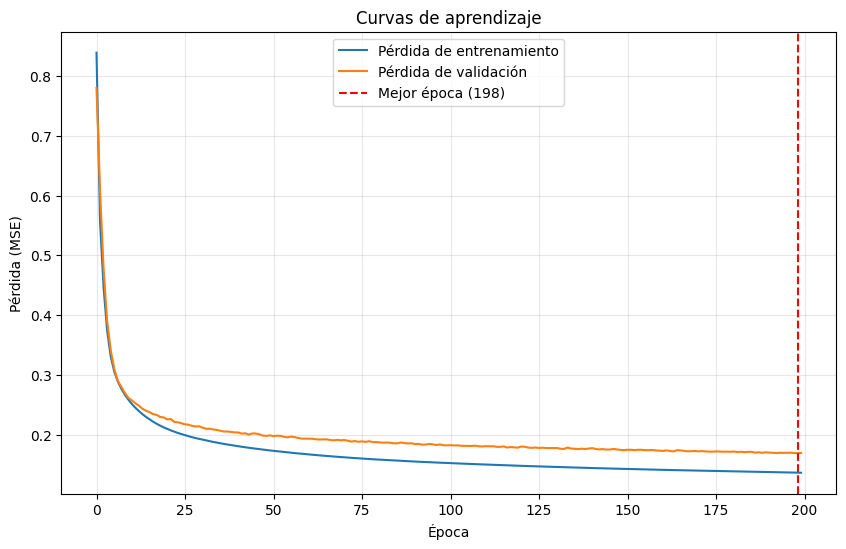

Predicción basada en reglas completa en 0.10 segundos


In [7]:
# Initialize JAX random key
key = random.PRNGKey(CONFIG["jax_seed"])

# Define model architecture
input_dim = 24 * 1 + X_other_train.shape[1]  # CGM (flattened) + other features
layer_sizes = [input_dim, 64, 32, 16, 1]
print(f"Arquitectura del modelo: {layer_sizes}")

# Initialize and train model
mlp_model = MLPModel(layer_sizes, activation=jax.nn.relu, key=key)
train_losses, val_losses, best_epoch = mlp_model.train(
    X_cgm_train, X_other_train, y_train,
    X_cgm_val, X_other_val, y_val,
    batch_size=CONFIG["batch_size"],
    learning_rate=1e-3,
    epochs=200,
    patience=20
)

# Plot learning curves
plot_learning_curves(train_losses, val_losses, best_epoch)

# Generate predictions on all sets
def generate_denormalized_predictions(model, X_cgm, X_other, scaler_y):
    """
    Genera predicciones desnormalizadas usando el modelo JAX.
    
    Args:
        model (MLPModel): Modelo entrenado
        X_cgm (jnp.ndarray): Datos CGM normalizados
        X_other (jnp.ndarray): Otras características normalizadas
        scaler_y (StandardScaler): Scaler para desnormalizar las predicciones
        
    Returns:
        np.ndarray: Predicciones desnormalizadas
    """
    # Generate normalized predictions
    predictions = model.predict(X_cgm, X_other)
    
    # Denormalize predictions
    predictions_np = np.array(predictions)
    denormalized_predictions = scaler_y.inverse_transform(predictions_np.reshape(-1, 1)).flatten()
    
    return denormalized_predictions

# Generate denormalized predictions for all sets
y_pred_jax_train = generate_denormalized_predictions(mlp_model, X_cgm_train, X_other_train, scaler_y)
y_pred_jax_val = generate_denormalized_predictions(mlp_model, X_cgm_val, X_other_val, scaler_y)
y_pred_jax_test = generate_denormalized_predictions(mlp_model, X_cgm_test, X_other_test, scaler_y)

# Generate rule-based predictions for comparison
y_rule = rule_based_prediction(X_other_test, scaler_other, scaler_y)

In [8]:
# Metrics for JAX MLP
mae_jax = mean_absolute_error(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_pred_jax_test)
rmse_jax = np.sqrt(mean_squared_error(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_pred_jax_test))
r2_jax = r2_score(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_pred_jax_test)
print(f"JAX MLP Test - MAE: {mae_jax:.2f}, RMSE: {rmse_jax:.2f}, R²: {r2_jax:.2f}")

# Metrics for the Rules-based model
mae_rule = mean_absolute_error(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_rule)
rmse_rule = np.sqrt(mean_squared_error(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_rule))
r2_rule = r2_score(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_rule)
print(f"Rules Test - MAE: {mae_rule:.2f}, RMSE: {rmse_rule:.2f}, R²: {r2_rule:.2f}")

JAX MLP Test - MAE: 0.26, RMSE: 0.36, R²: 0.71
Rules Test - MAE: 0.97, RMSE: 1.18, R²: -2.08


In [9]:
# Metrics for train
mae_jax_train = mean_absolute_error(scaler_y.inverse_transform(np.array(y_train).reshape(-1, 1)), y_pred_jax_train)
rmse_jax_train = np.sqrt(mean_squared_error(scaler_y.inverse_transform(np.array(y_train).reshape(-1, 1)), y_pred_jax_train))
r2_jax_train = r2_score(scaler_y.inverse_transform(np.array(y_train).reshape(-1, 1)), y_pred_jax_train)
print(f"JAX MLP Train - MAE: {mae_jax_train:.2f}, RMSE: {rmse_jax_train:.2f}, R²: {r2_jax_train:.2f}")

# Metrics for validation
mae_jax_val = mean_absolute_error(scaler_y.inverse_transform(np.array(y_val).reshape(-1, 1)), y_pred_jax_val)
rmse_jax_val = np.sqrt(mean_squared_error(scaler_y.inverse_transform(np.array(y_val).reshape(-1, 1)), y_pred_jax_val))
r2_jax_val = r2_score(scaler_y.inverse_transform(np.array(y_val).reshape(-1, 1)), y_pred_jax_val)
print(f"JAX MLP Val - MAE: {mae_jax_val:.2f}, RMSE: {rmse_jax_val:.2f}, R²: {r2_jax_val:.2f}")

# Metrics for test (already computed)
print(f"JAX MLP Test - MAE: {mae_jax:.2f}, RMSE: {rmse_jax:.2f}, R²: {r2_jax:.2f}")

JAX MLP Train - MAE: 0.16, RMSE: 0.24, R²: 0.86
JAX MLP Val - MAE: 0.16, RMSE: 0.27, R²: 0.84
JAX MLP Test - MAE: 0.26, RMSE: 0.36, R²: 0.71


In [10]:
from sklearn.model_selection import KFold

def run_cv_fold_jax(train_subs, test_subs, df_final_pd, cgm_columns, other_features):
    """
    Ejecuta un fold de validación cruzada para el modelo JAX MLP.
    
    Args:
        train_subs (np.ndarray): IDs de sujetos para entrenamiento
        test_subs (np.ndarray): IDs de sujetos para prueba
        df_final_pd (pd.DataFrame): DataFrame con datos procesados
        cgm_columns (list): Lista de columnas CGM
        other_features (list): Lista de otras características
        
    Returns:
        float: MAE en el conjunto de prueba
    """
    # Create train and test masks
    train_mask = df_final_pd['subject_id'].isin(train_subs)
    test_mask = df_final_pd['subject_id'].isin(test_subs)
    
    # Scale features
    X_cgm_train_cv = scaler_cgm.transform(df_final_pd.loc[train_mask, cgm_columns]).reshape(-1, 24, 1)
    X_other_train_cv = scaler_other.transform(df_final_pd.loc[train_mask, other_features])
    y_train_cv = scaler_y.transform(df_final_pd.loc[train_mask, 'normal'].values.reshape(-1, 1)).flatten()
    
    X_cgm_test_cv = scaler_cgm.transform(df_final_pd.loc[test_mask, cgm_columns]).reshape(-1, 24, 1)
    X_other_test_cv = scaler_other.transform(df_final_pd.loc[test_mask, other_features])
    y_test_cv = scaler_y.transform(df_final_pd.loc[test_mask, 'normal'].values.reshape(-1, 1)).flatten()
    
    # Convert to JAX arrays
    X_cgm_train_cv = jnp.array(X_cgm_train_cv)
    X_other_train_cv = jnp.array(X_other_train_cv)
    y_train_cv = jnp.array(y_train_cv)
    X_cgm_test_cv = jnp.array(X_cgm_test_cv)
    X_other_test_cv = jnp.array(X_other_test_cv)
    y_test_cv = jnp.array(y_test_cv)
    
    # Define model
    input_dim = 24 * 1 + X_other_train_cv.shape[1]
    layer_sizes = [input_dim, 64, 32, 16, 1]
    key = random.PRNGKey(int(time.time()) % 10000)  # Random seed
    
    # Train model
    model_cv = MLPModel(layer_sizes, activation=jax.nn.relu, key=key)
    model_cv.train(
        X_cgm_train_cv, X_other_train_cv, y_train_cv,
        X_cgm_test_cv, X_other_test_cv, y_test_cv,
        batch_size=CONFIG["batch_size"],
        learning_rate=1e-3,
        epochs=100,
        patience=10
    )
    
    # Generate predictions
    y_pred_cv = generate_denormalized_predictions(model_cv, X_cgm_test_cv, X_other_test_cv, scaler_y)
    
    # Calculate MAE
    return mean_absolute_error(scaler_y.inverse_transform(np.array(y_test_cv).reshape(-1, 1)), y_pred_cv)

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
subject_ids = df_final['subject_id'].unique().to_numpy()
mae_scores = []
cgm_columns = [f'cgm_{i}' for i in range(24)]
other_features = ['carbInput', 'bgInput', 'insulinOnBoard', 'insulinCarbRatio', 
                  'insulinSensitivityFactor', 'hour_of_day']

# Convert to pandas for KFold
df_final_pd = df_final.to_pandas()

# Perform cross-validation
for train_idx, test_idx in kf.split(subject_ids):
    train_subs = subject_ids[train_idx]
    test_subs = subject_ids[test_idx]
    mae_cv = run_cv_fold_jax(train_subs, test_subs, df_final_pd, cgm_columns, other_features)
    mae_scores.append(mae_cv)

print(f"Cross-validated JAX MLP MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")

Época 0: Pérdida entrenamiento = 0.7761, Pérdida validación = 0.5801
Época 10: Pérdida entrenamiento = 0.2362, Pérdida validación = 0.3110
Época 20: Pérdida entrenamiento = 0.1994, Pérdida validación = 0.2792
Época 30: Pérdida entrenamiento = 0.1828, Pérdida validación = 0.2631
Época 40: Pérdida entrenamiento = 0.1728, Pérdida validación = 0.2529
Época 50: Pérdida entrenamiento = 0.1658, Pérdida validación = 0.2485
Época 60: Pérdida entrenamiento = 0.1606, Pérdida validación = 0.2356
Época 70: Pérdida entrenamiento = 0.1564, Pérdida validación = 0.2314
Época 80: Pérdida entrenamiento = 0.1527, Pérdida validación = 0.2260
Época 90: Pérdida entrenamiento = 0.1496, Pérdida validación = 0.2203
Época 99: Pérdida entrenamiento = 0.1471, Pérdida validación = 0.2126
Época 0: Pérdida entrenamiento = 1.0959, Pérdida validación = 0.7228
Época 10: Pérdida entrenamiento = 0.2462, Pérdida validación = 0.2501
Época 20: Pérdida entrenamiento = 0.2063, Pérdida validación = 0.1969
Época 30: Pérdida entr

Train y: mean = 1.2717513003802827 std = 0.6616772959835082
Val y: mean = 1.2065190640659182 std = 0.6887786986272488
Test y: mean = 0.9719885219738372 std = 0.6732460904580183


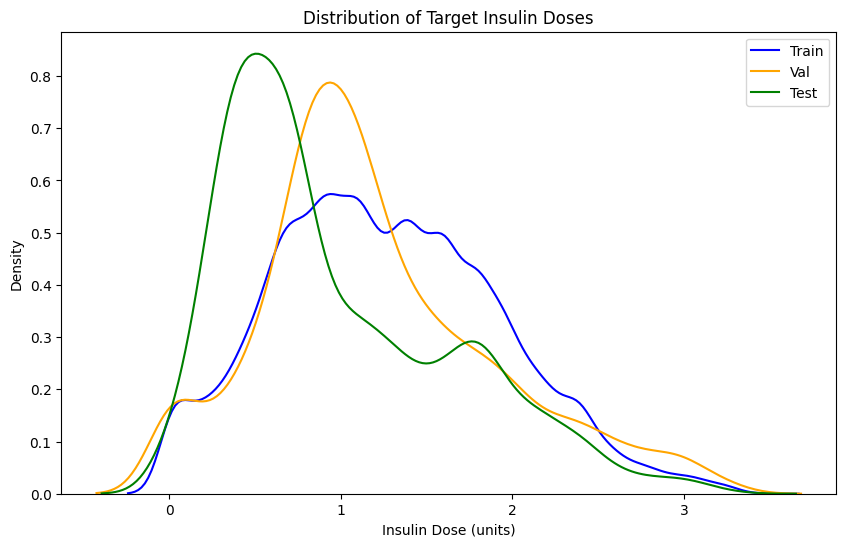

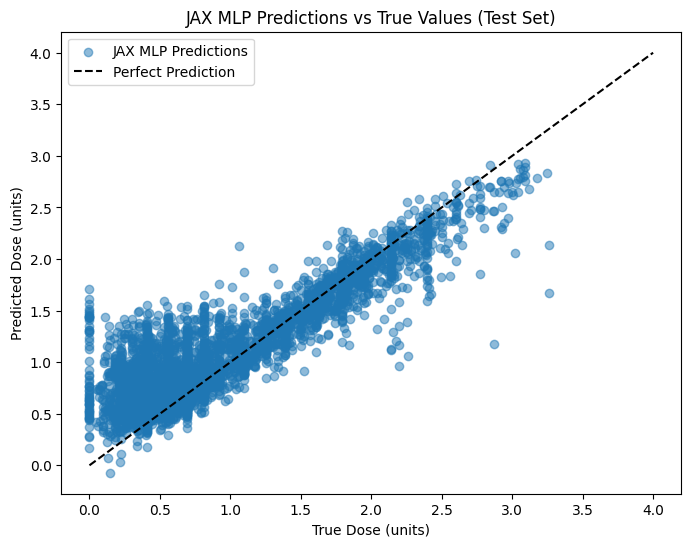

In [11]:
y_train_denorm = scaler_y.inverse_transform(np.array(y_train).reshape(-1, 1)).flatten()
y_val_denorm = scaler_y.inverse_transform(np.array(y_val).reshape(-1, 1)).flatten()
y_test_denorm = scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()

print("Train y: mean =", np.mean(y_train_denorm), "std =", np.std(y_train_denorm))
print("Val y: mean =", np.mean(y_val_denorm), "std =", np.std(y_val_denorm))
print("Test y: mean =", np.mean(y_test_denorm), "std =", np.std(y_test_denorm))

plt.figure(figsize=(10, 6))
sns.kdeplot(y_train_denorm, label='Train', color='blue')
sns.kdeplot(y_val_denorm, label='Val', color='orange')
sns.kdeplot(y_test_denorm, label='Test', color='green')
plt.xlabel('Insulin Dose (units)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Target Insulin Doses')
plt.show()

# Plot predictions vs true values for test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test_denorm, y_pred_jax_test, alpha=0.5, label='JAX MLP Predictions')
plt.plot([0, 4], [0, 4], 'k--', label='Perfect Prediction')
plt.xlabel('True Dose (units)')
plt.ylabel('Predicted Dose (units)')
plt.legend()
plt.title('JAX MLP Predictions vs True Values (Test Set)')
plt.show()

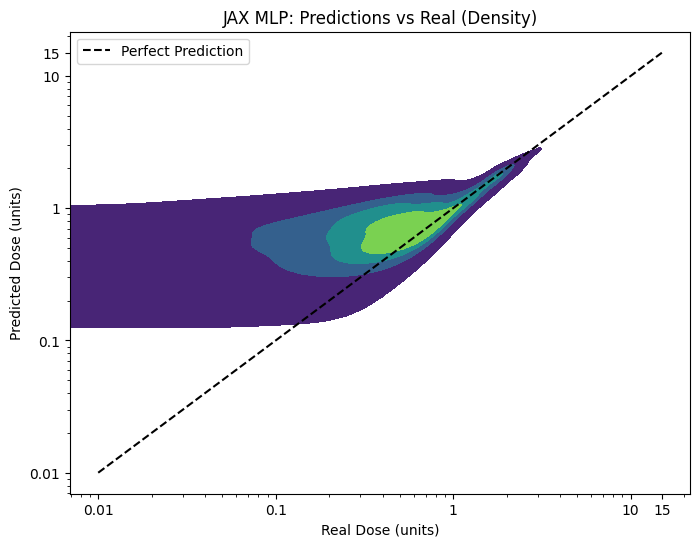

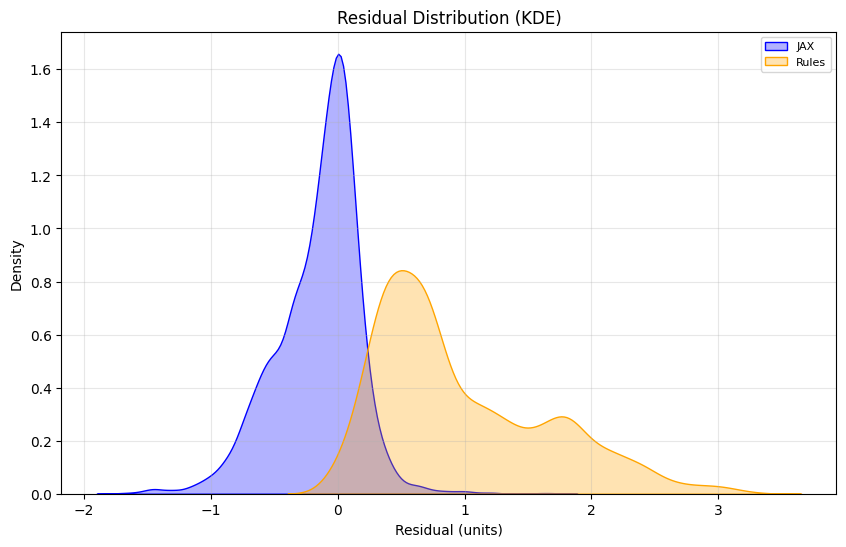

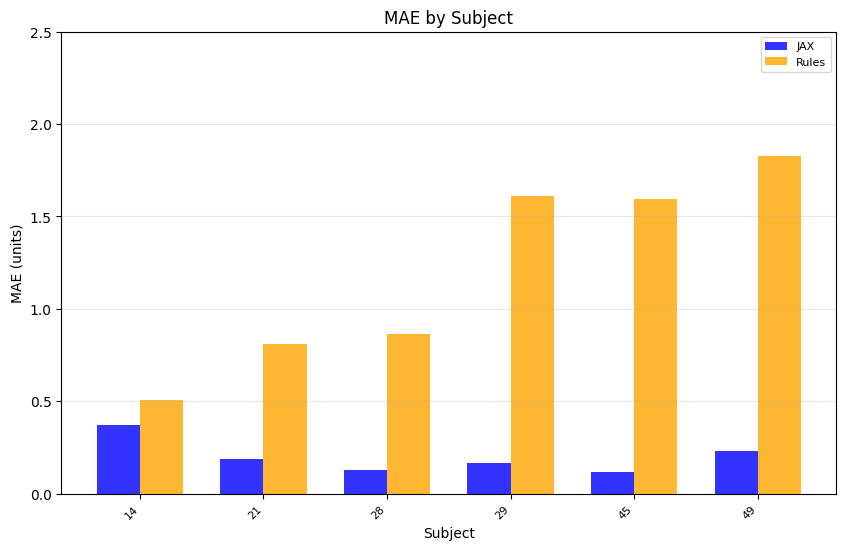

Visualización completa en 0.89 segundos


In [12]:
# Visualize the results
plot_evaluation(y_test, y_pred_jax_test, y_rule, subject_test, scaler_y)


Rendimiento por sujeto (Test Set):
Sujeto 14: JAX MLP MAE=0.37, Rules MAE=0.51
Sujeto 21: JAX MLP MAE=0.19, Rules MAE=0.81
Sujeto 28: JAX MLP MAE=0.13, Rules MAE=0.86
Sujeto 29: JAX MLP MAE=0.17, Rules MAE=1.61
Sujeto 45: JAX MLP MAE=0.11, Rules MAE=1.60
Sujeto 49: JAX MLP MAE=0.23, Rules MAE=1.83
Subject 49 - Mean dose: 1.83, Std: 0.67


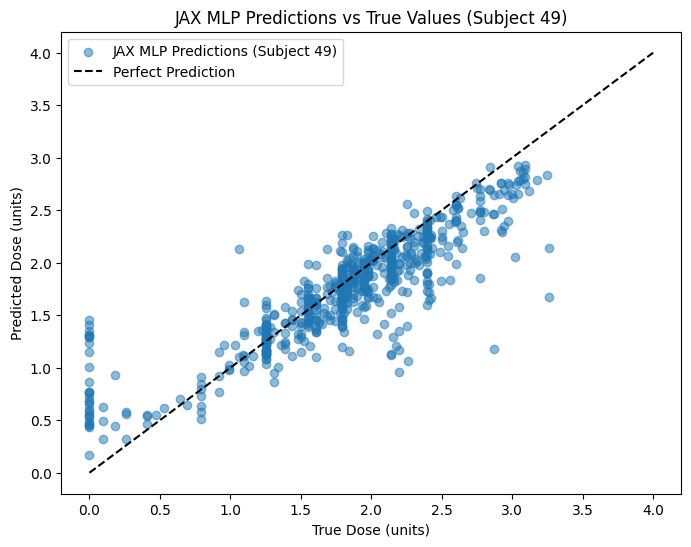

In [13]:
# Analyze performance per subject
print("\nRendimiento por sujeto (Test Set):")
for subject_id in np.unique(subject_test):
    mask = subject_test == subject_id
    if np.sum(mask) > 0:
        y_test_sub = scaler_y.inverse_transform(np.array(y_test)[mask].reshape(-1, 1)).flatten()
        print(f"Sujeto {subject_id}: ", end="")
        mae_jax_sub = mean_absolute_error(y_test_sub, y_pred_jax_test[mask])
        print(f"JAX MLP MAE={mae_jax_sub:.2f}, ", end="")
        mae_rule_sub = mean_absolute_error(y_test_sub, y_rule[mask])
        print(f"Rules MAE={mae_rule_sub:.2f}")

# Check if subject 49 exists in test set
if 49 in np.unique(subject_test):
    mask_49 = subject_test == 49
    y_test_49 = scaler_y.inverse_transform(np.array(y_test)[mask_49].reshape(-1, 1)).flatten()
    print(f"Subject 49 - Mean dose: {y_test_49.mean():.2f}, Std: {y_test_49.std():.2f}")
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_49, y_pred_jax_test[mask_49], alpha=0.5, label='JAX MLP Predictions (Subject 49)')
    plt.plot([0, 4], [0, 4], 'k--', label='Perfect Prediction')
    plt.xlabel('True Dose (units)')
    plt.ylabel('Predicted Dose (units)')
    plt.legend()
    plt.title('JAX MLP Predictions vs True Values (Subject 49)')
    plt.show()
else:
    print("Subject 49 not found in test set")


Training JAX MLP with learning rate 0.001 and architecture [30, 64, 32, 16, 1]:
Época 0: Pérdida entrenamiento = 0.7303, Pérdida validación = 0.5131
Época 10: Pérdida entrenamiento = 0.2384, Pérdida validación = 0.2712
Época 20: Pérdida entrenamiento = 0.2022, Pérdida validación = 0.2292
Época 30: Pérdida entrenamiento = 0.1858, Pérdida validación = 0.2112
Época 40: Pérdida entrenamiento = 0.1760, Pérdida validación = 0.2032
Época 50: Pérdida entrenamiento = 0.1691, Pérdida validación = 0.1941
Época 60: Pérdida entrenamiento = 0.1639, Pérdida validación = 0.1882
Época 70: Pérdida entrenamiento = 0.1597, Pérdida validación = 0.1876
Época 80: Pérdida entrenamiento = 0.1563, Pérdida validación = 0.1807
Época 90: Pérdida entrenamiento = 0.1533, Pérdida validación = 0.1769
Época 100: Pérdida entrenamiento = 0.1507, Pérdida validación = 0.1733
Época 110: Pérdida entrenamiento = 0.1484, Pérdida validación = 0.1726
Época 120: Pérdida entrenamiento = 0.1463, Pérdida validación = 0.1694
Época 1

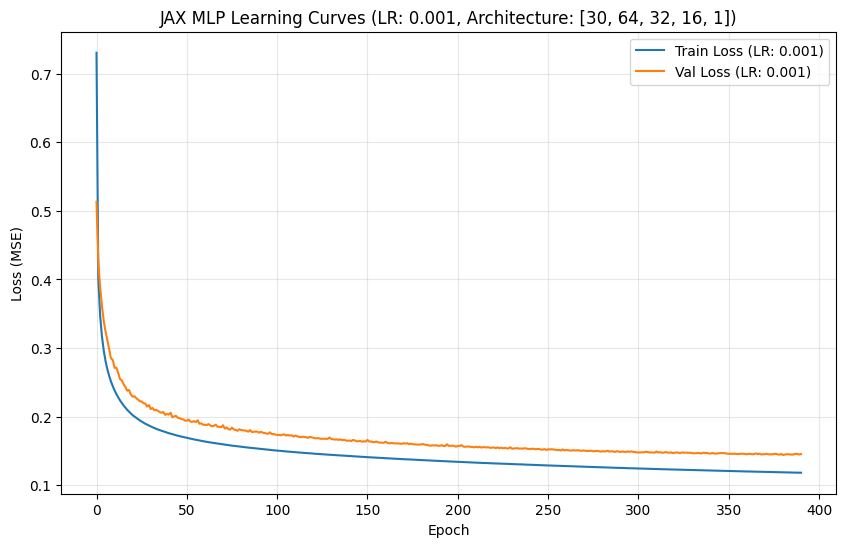


Training JAX MLP with learning rate 0.001 and architecture [30, 128, 64, 32, 1]:
Época 0: Pérdida entrenamiento = 0.6022, Pérdida validación = 0.5313
Época 10: Pérdida entrenamiento = 0.2095, Pérdida validación = 0.2563
Época 20: Pérdida entrenamiento = 0.1822, Pérdida validación = 0.2254
Época 30: Pérdida entrenamiento = 0.1693, Pérdida validación = 0.2060
Época 40: Pérdida entrenamiento = 0.1617, Pérdida validación = 0.1954
Época 50: Pérdida entrenamiento = 0.1563, Pérdida validación = 0.1955
Época 60: Pérdida entrenamiento = 0.1521, Pérdida validación = 0.1837
Época 70: Pérdida entrenamiento = 0.1486, Pérdida validación = 0.1795
Época 80: Pérdida entrenamiento = 0.1456, Pérdida validación = 0.1761
Época 90: Pérdida entrenamiento = 0.1430, Pérdida validación = 0.1733
Época 100: Pérdida entrenamiento = 0.1403, Pérdida validación = 0.1719
Época 110: Pérdida entrenamiento = 0.1380, Pérdida validación = 0.1696
Época 120: Pérdida entrenamiento = 0.1358, Pérdida validación = 0.1671
Época 

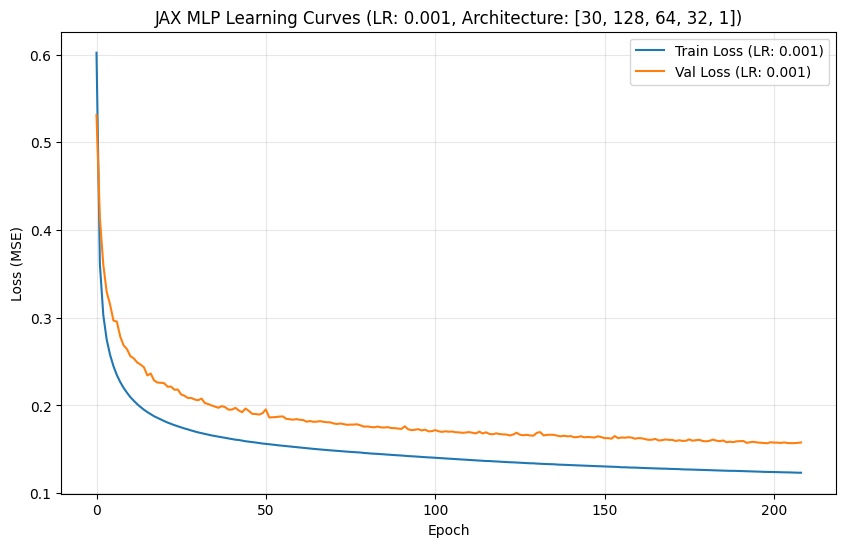


Training JAX MLP with learning rate 0.0005 and architecture [30, 64, 32, 16, 1]:
Época 0: Pérdida entrenamiento = 1.0793, Pérdida validación = 0.9655
Época 10: Pérdida entrenamiento = 0.3487, Pérdida validación = 0.3772
Época 20: Pérdida entrenamiento = 0.2698, Pérdida validación = 0.3004
Época 30: Pérdida entrenamiento = 0.2358, Pérdida validación = 0.2631
Época 40: Pérdida entrenamiento = 0.2157, Pérdida validación = 0.2416
Época 50: Pérdida entrenamiento = 0.2024, Pérdida validación = 0.2289
Época 60: Pérdida entrenamiento = 0.1929, Pérdida validación = 0.2201
Época 70: Pérdida entrenamiento = 0.1856, Pérdida validación = 0.2139
Época 80: Pérdida entrenamiento = 0.1799, Pérdida validación = 0.2097
Época 90: Pérdida entrenamiento = 0.1753, Pérdida validación = 0.2071
Época 100: Pérdida entrenamiento = 0.1715, Pérdida validación = 0.2038
Época 110: Pérdida entrenamiento = 0.1683, Pérdida validación = 0.2018
Época 120: Pérdida entrenamiento = 0.1655, Pérdida validación = 0.2000
Época 

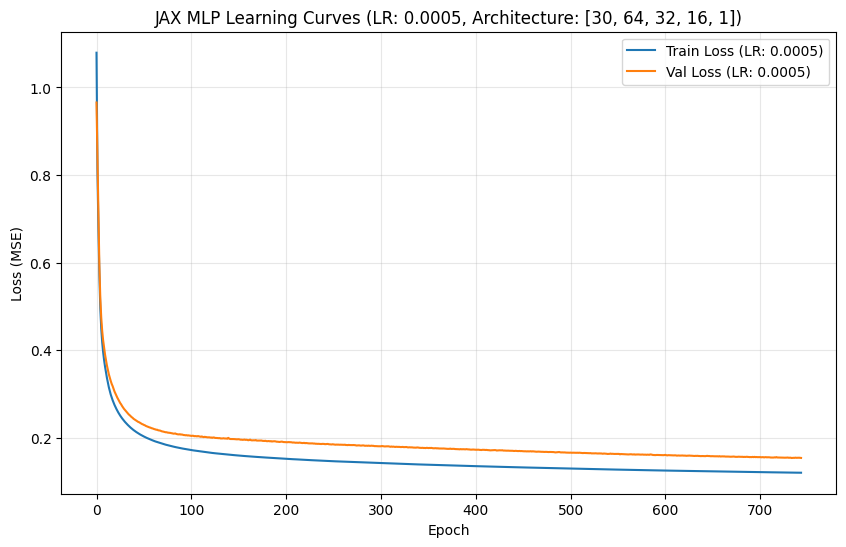


Training JAX MLP with learning rate 0.0005 and architecture [30, 128, 64, 32, 1]:
Época 0: Pérdida entrenamiento = 0.8816, Pérdida validación = 0.8456
Época 10: Pérdida entrenamiento = 0.2615, Pérdida validación = 0.2984
Época 20: Pérdida entrenamiento = 0.2213, Pérdida validación = 0.2544
Época 30: Pérdida entrenamiento = 0.2027, Pérdida validación = 0.2327
Época 40: Pérdida entrenamiento = 0.1912, Pérdida validación = 0.2164
Época 50: Pérdida entrenamiento = 0.1829, Pérdida validación = 0.2060
Época 60: Pérdida entrenamiento = 0.1766, Pérdida validación = 0.1984
Época 70: Pérdida entrenamiento = 0.1714, Pérdida validación = 0.1962
Época 80: Pérdida entrenamiento = 0.1671, Pérdida validación = 0.1892
Época 90: Pérdida entrenamiento = 0.1634, Pérdida validación = 0.1875
Época 100: Pérdida entrenamiento = 0.1602, Pérdida validación = 0.1827
Época 110: Pérdida entrenamiento = 0.1573, Pérdida validación = 0.1795
Época 120: Pérdida entrenamiento = 0.1547, Pérdida validación = 0.1773
Época

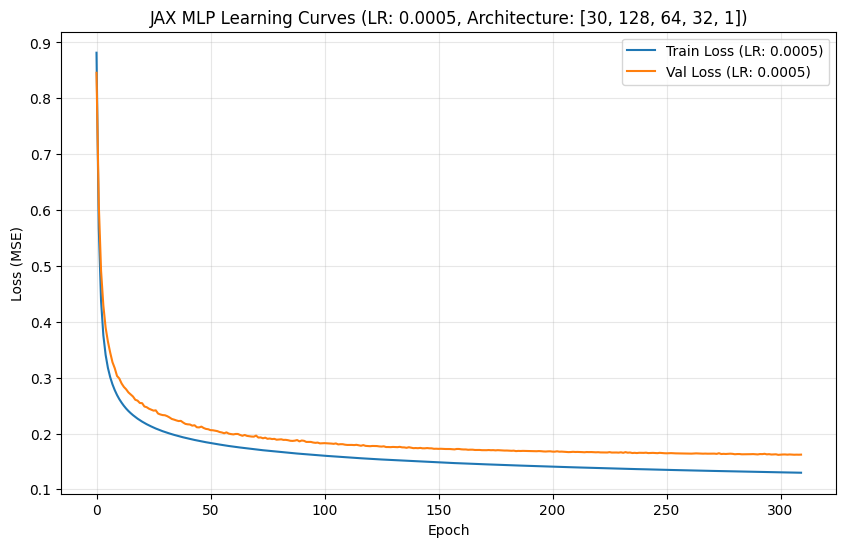


Training JAX MLP with learning rate 0.0003 and architecture [30, 64, 32, 16, 1]:
Época 0: Pérdida entrenamiento = 1.2982, Pérdida validación = 1.0531
Época 10: Pérdida entrenamiento = 0.3451, Pérdida validación = 0.3994
Época 20: Pérdida entrenamiento = 0.2614, Pérdida validación = 0.2984
Época 30: Pérdida entrenamiento = 0.2352, Pérdida validación = 0.2666
Época 40: Pérdida entrenamiento = 0.2213, Pérdida validación = 0.2507
Época 50: Pérdida entrenamiento = 0.2119, Pérdida validación = 0.2409
Época 60: Pérdida entrenamiento = 0.2049, Pérdida validación = 0.2315
Época 70: Pérdida entrenamiento = 0.1993, Pérdida validación = 0.2260
Época 80: Pérdida entrenamiento = 0.1947, Pérdida validación = 0.2216
Época 90: Pérdida entrenamiento = 0.1908, Pérdida validación = 0.2164
Época 100: Pérdida entrenamiento = 0.1874, Pérdida validación = 0.2123
Época 110: Pérdida entrenamiento = 0.1845, Pérdida validación = 0.2098
Época 120: Pérdida entrenamiento = 0.1818, Pérdida validación = 0.2060
Época 

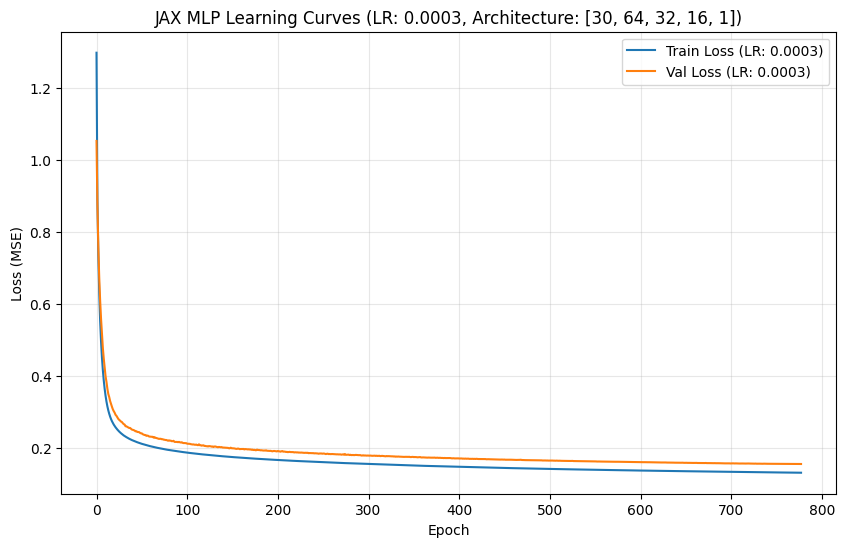


Training JAX MLP with learning rate 0.0003 and architecture [30, 128, 64, 32, 1]:
Época 0: Pérdida entrenamiento = 0.7638, Pérdida validación = 0.6882
Época 10: Pérdida entrenamiento = 0.2578, Pérdida validación = 0.2934
Época 20: Pérdida entrenamiento = 0.2235, Pérdida validación = 0.2539
Época 30: Pérdida entrenamiento = 0.2073, Pérdida validación = 0.2378
Época 40: Pérdida entrenamiento = 0.1969, Pérdida validación = 0.2256
Época 50: Pérdida entrenamiento = 0.1893, Pérdida validación = 0.2185
Época 60: Pérdida entrenamiento = 0.1835, Pérdida validación = 0.2116
Época 70: Pérdida entrenamiento = 0.1789, Pérdida validación = 0.2063
Época 80: Pérdida entrenamiento = 0.1751, Pérdida validación = 0.2018
Época 90: Pérdida entrenamiento = 0.1719, Pérdida validación = 0.1985
Época 100: Pérdida entrenamiento = 0.1690, Pérdida validación = 0.1961
Época 110: Pérdida entrenamiento = 0.1665, Pérdida validación = 0.1934
Época 120: Pérdida entrenamiento = 0.1643, Pérdida validación = 0.1915
Época

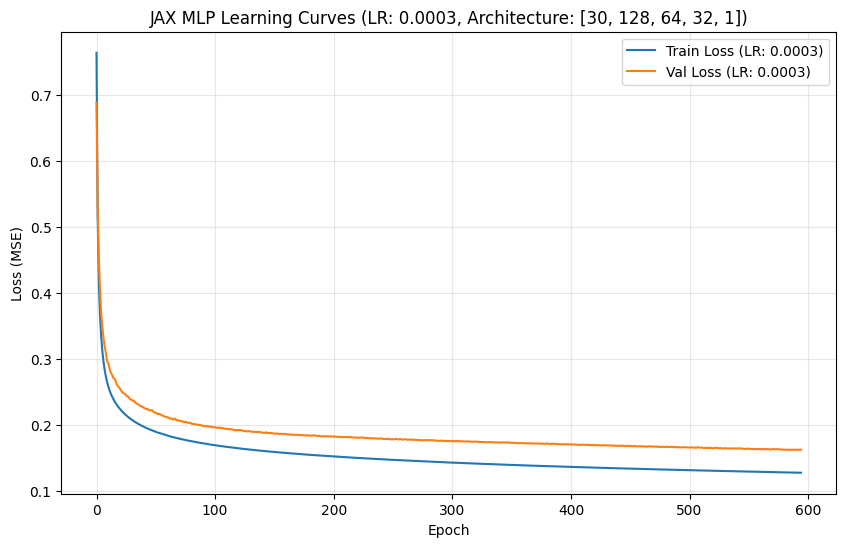


Training JAX MLP with learning rate 0.0001 and architecture [30, 64, 32, 16, 1]:
Época 0: Pérdida entrenamiento = 1.2834, Pérdida validación = 0.8330
Época 10: Pérdida entrenamiento = 0.4720, Pérdida validación = 0.4679
Época 20: Pérdida entrenamiento = 0.3908, Pérdida validación = 0.4105
Época 30: Pérdida entrenamiento = 0.3497, Pérdida validación = 0.3835
Época 40: Pérdida entrenamiento = 0.3210, Pérdida validación = 0.3627
Época 50: Pérdida entrenamiento = 0.2990, Pérdida validación = 0.3459
Época 60: Pérdida entrenamiento = 0.2813, Pérdida validación = 0.3322
Época 70: Pérdida entrenamiento = 0.2668, Pérdida validación = 0.3183
Época 80: Pérdida entrenamiento = 0.2547, Pérdida validación = 0.3071
Época 90: Pérdida entrenamiento = 0.2444, Pérdida validación = 0.2967
Época 100: Pérdida entrenamiento = 0.2358, Pérdida validación = 0.2884
Época 110: Pérdida entrenamiento = 0.2285, Pérdida validación = 0.2806
Época 120: Pérdida entrenamiento = 0.2223, Pérdida validación = 0.2739
Época 

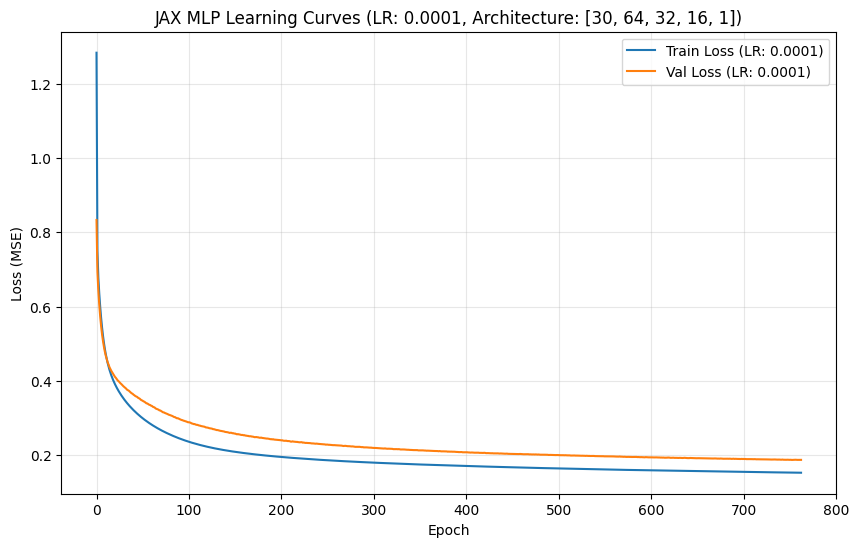


Training JAX MLP with learning rate 0.0001 and architecture [30, 128, 64, 32, 1]:
Época 0: Pérdida entrenamiento = 1.0772, Pérdida validación = 0.9594
Época 10: Pérdida entrenamiento = 0.4064, Pérdida validación = 0.4957
Época 20: Pérdida entrenamiento = 0.3303, Pérdida validación = 0.4028
Época 30: Pérdida entrenamiento = 0.2982, Pérdida validación = 0.3590
Época 40: Pérdida entrenamiento = 0.2778, Pérdida validación = 0.3321
Época 50: Pérdida entrenamiento = 0.2631, Pérdida validación = 0.3151
Época 60: Pérdida entrenamiento = 0.2516, Pérdida validación = 0.3020
Época 70: Pérdida entrenamiento = 0.2422, Pérdida validación = 0.2920
Época 80: Pérdida entrenamiento = 0.2344, Pérdida validación = 0.2823
Época 90: Pérdida entrenamiento = 0.2277, Pérdida validación = 0.2754
Época 100: Pérdida entrenamiento = 0.2220, Pérdida validación = 0.2682
Época 110: Pérdida entrenamiento = 0.2169, Pérdida validación = 0.2616
Época 120: Pérdida entrenamiento = 0.2125, Pérdida validación = 0.2564
Época

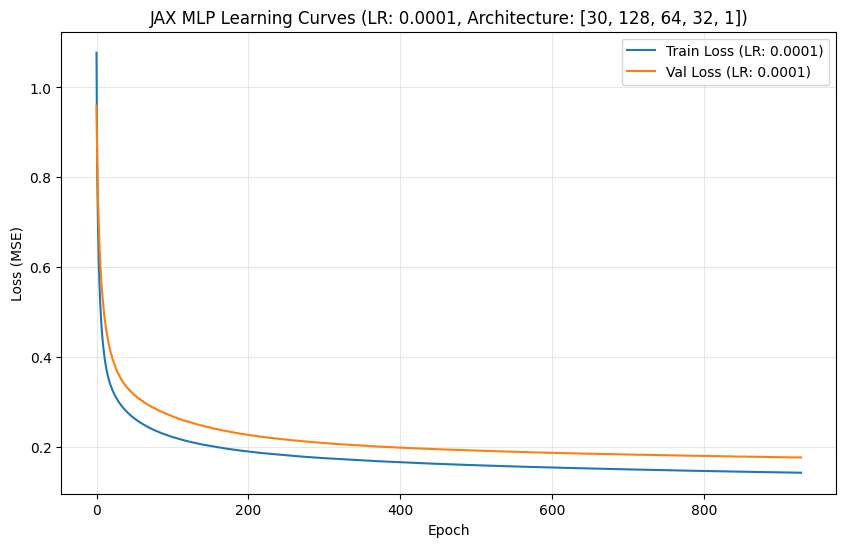


Training JAX MLP with learning rate 5e-05 and architecture [30, 64, 32, 16, 1]:
Época 0: Pérdida entrenamiento = 2.1525, Pérdida validación = 1.1782
Época 10: Pérdida entrenamiento = 0.6842, Pérdida validación = 0.7175
Época 20: Pérdida entrenamiento = 0.5248, Pérdida validación = 0.5573
Época 30: Pérdida entrenamiento = 0.4346, Pérdida validación = 0.4670
Época 40: Pérdida entrenamiento = 0.3795, Pérdida validación = 0.4151
Época 50: Pérdida entrenamiento = 0.3444, Pérdida validación = 0.3837
Época 60: Pérdida entrenamiento = 0.3207, Pérdida validación = 0.3626
Época 70: Pérdida entrenamiento = 0.3038, Pérdida validación = 0.3473
Época 80: Pérdida entrenamiento = 0.2908, Pérdida validación = 0.3348
Época 90: Pérdida entrenamiento = 0.2804, Pérdida validación = 0.3250
Época 100: Pérdida entrenamiento = 0.2720, Pérdida validación = 0.3166
Época 110: Pérdida entrenamiento = 0.2650, Pérdida validación = 0.3102
Época 120: Pérdida entrenamiento = 0.2591, Pérdida validación = 0.3048
Época 1

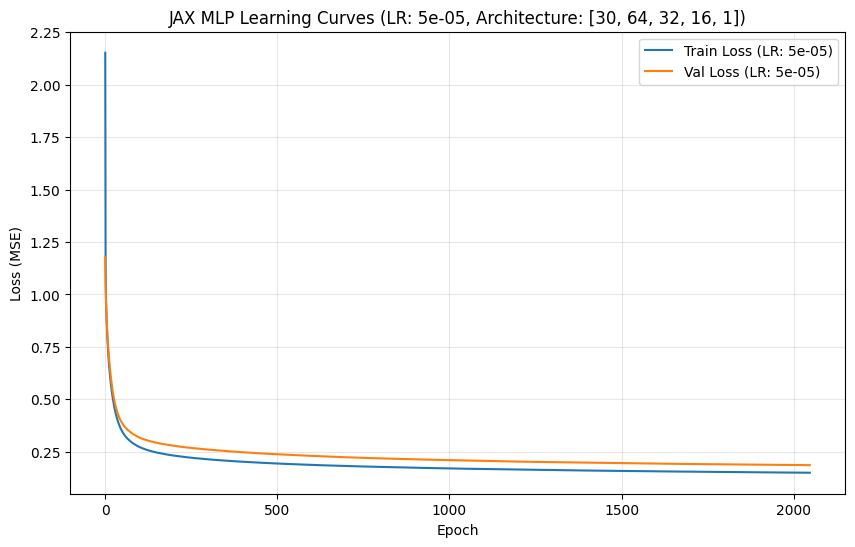


Training JAX MLP with learning rate 5e-05 and architecture [30, 128, 64, 32, 1]:
Época 0: Pérdida entrenamiento = 1.1981, Pérdida validación = 1.2683
Época 10: Pérdida entrenamiento = 0.7189, Pérdida validación = 0.7962
Época 20: Pérdida entrenamiento = 0.5648, Pérdida validación = 0.6109
Época 30: Pérdida entrenamiento = 0.4822, Pérdida validación = 0.5191
Época 40: Pérdida entrenamiento = 0.4290, Pérdida validación = 0.4682
Época 50: Pérdida entrenamiento = 0.3906, Pérdida validación = 0.4334
Época 60: Pérdida entrenamiento = 0.3615, Pérdida validación = 0.4081
Época 70: Pérdida entrenamiento = 0.3390, Pérdida validación = 0.3872
Época 80: Pérdida entrenamiento = 0.3212, Pérdida validación = 0.3696
Época 90: Pérdida entrenamiento = 0.3069, Pérdida validación = 0.3550
Época 100: Pérdida entrenamiento = 0.2951, Pérdida validación = 0.3419
Época 110: Pérdida entrenamiento = 0.2853, Pérdida validación = 0.3302
Época 120: Pérdida entrenamiento = 0.2769, Pérdida validación = 0.3193
Época 

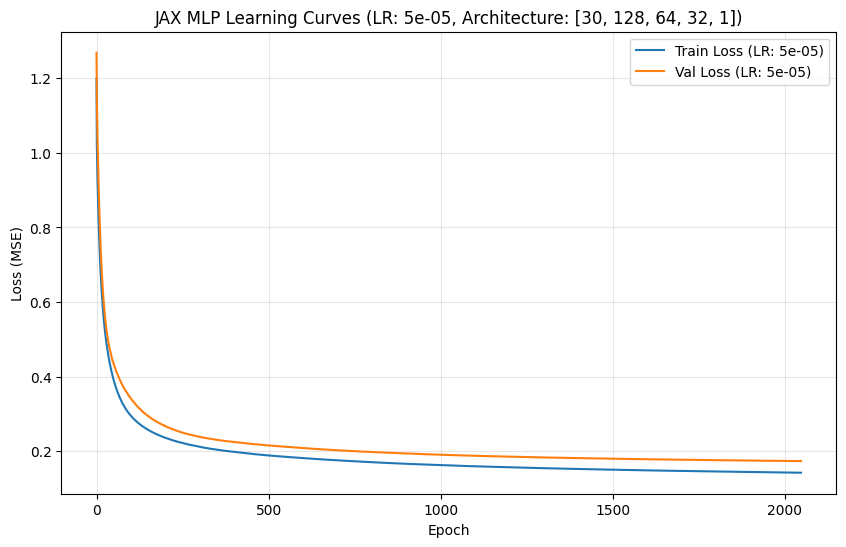


Summary of all JAX MLP Tuning Results:
LR: 0.001, Architecture: [30, 128, 64, 32, 1], MAE: 0.20, RMSE: 0.29, R²: 0.82, Best Epoch: 198
LR: 0.0005, Architecture: [30, 64, 32, 16, 1], MAE: 0.21, RMSE: 0.30, R²: 0.80, Best Epoch: 733
LR: 0.001, Architecture: [30, 64, 32, 16, 1], MAE: 0.21, RMSE: 0.31, R²: 0.79, Best Epoch: 380
LR: 0.0003, Architecture: [30, 128, 64, 32, 1], MAE: 0.22, RMSE: 0.31, R²: 0.79, Best Epoch: 584
LR: 0.0001, Architecture: [30, 128, 64, 32, 1], MAE: 0.23, RMSE: 0.32, R²: 0.78, Best Epoch: 918
LR: 5e-05, Architecture: [30, 128, 64, 32, 1], MAE: 0.23, RMSE: 0.32, R²: 0.77, Best Epoch: 2046
LR: 5e-05, Architecture: [30, 64, 32, 16, 1], MAE: 0.23, RMSE: 0.32, R²: 0.77, Best Epoch: 2045
LR: 0.0001, Architecture: [30, 64, 32, 16, 1], MAE: 0.25, RMSE: 0.35, R²: 0.74, Best Epoch: 752
LR: 0.0003, Architecture: [30, 64, 32, 16, 1], MAE: 0.26, RMSE: 0.37, R²: 0.71, Best Epoch: 767
LR: 0.0005, Architecture: [30, 128, 64, 32, 1], MAE: 0.30, RMSE: 0.42, R²: 0.61, Best Epoch: 2

In [14]:
# Test different learning rates and architectures
learning_rates = [1e-3, 7e-4, 5e-4, 3e-4, 1e-4]
architectures = [
    [input_dim, 64, 32, 16, 1],
    [input_dim, 128, 64, 32, 1]
]

results = []
for lr in learning_rates:
    for arch in architectures:
        print(f"\nTraining JAX MLP with learning rate {lr} and architecture {arch}:")
        
        # Initialize model with current architecture
        model_tune = MLPModel(arch, activation=jax.nn.relu, key=random.PRNGKey(int(time.time()) % 10000))
        
        # Train model with current learning rate
        train_losses, val_losses, best_epoch = model_tune.train(
            X_cgm_train, X_other_train, y_train,
            X_cgm_val, X_other_val, y_val,
            batch_size=CONFIG["batch_size"],
            learning_rate=lr,
            epochs=2048,
            patience=10
        )
        
        # Generate predictions on test set
        y_pred_jax_test_tune = generate_denormalized_predictions(model_tune, X_cgm_test, X_other_test, scaler_y)
        
        # Calculate metrics
        mae_tune = mean_absolute_error(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_pred_jax_test_tune)
        rmse_tune = np.sqrt(mean_squared_error(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_pred_jax_test_tune))
        r2_tune = r2_score(scaler_y.inverse_transform(np.array(y_test).reshape(-1, 1)), y_pred_jax_test_tune)
        
        print(f"JAX MLP Test (LR: {lr}, Arch: {arch}) - MAE: {mae_tune:.2f}, RMSE: {rmse_tune:.2f}, R²: {r2_tune:.2f}")
        
        # Plot learning curves
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label=f'Train Loss (LR: {lr})')
        plt.plot(val_losses, label=f'Val Loss (LR: {lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.title(f'JAX MLP Learning Curves (LR: {lr}, Architecture: {arch})')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Store results
        results.append({
            'learning_rate': lr,
            'architecture': arch,
            'mae': mae_tune,
            'rmse': rmse_tune,
            'r2': r2_tune,
            'best_epoch': best_epoch
        })

# Print summary of all results
print("\nSummary of all JAX MLP Tuning Results:")
for result in sorted(results, key=lambda x: x['mae']):
    print(f"LR: {result['learning_rate']}, Architecture: {result['architecture']}, "
          f"MAE: {result['mae']:.2f}, RMSE: {result['rmse']:.2f}, R²: {result['r2']:.2f}, "
          f"Best Epoch: {result['best_epoch']}")